#**Pré-processamento de Dados NDVI e Clima**

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Carregar dados de NDVI e ajustar colunas
ndvi = pd.read_excel('satveg_planilha.xlsx', skiprows=3)
ndvi.columns = ['Data', 'NDVI', 'NDVI_lower', 'NDVI_upper']
ndvi['Data'] = pd.to_datetime(ndvi['Data'], dayfirst=True, errors='coerce')
ndvi.set_index('Data', inplace=True)

# 2. Preencher falhas com interpolação e suavizar série com média móvel de 7 dias
ndvi['NDVI'] = ndvi['NDVI'].interpolate('time')
ndvi['NDVI_smooth'] = ndvi['NDVI'].rolling(window=7, center=True).mean()

# 3. Definir ano agrícola (julho de um ano até junho do ano seguinte)
ndvi['Ano_Agricola'] = np.where(ndvi.index.month >= 7, ndvi.index.year + 1, ndvi.index.year)

# 4. Agrupar dados NDVI por ano agrícola com estatísticas básicas
features = ndvi.groupby('Ano_Agricola')['NDVI_smooth'].agg(
    NDVI_max='max',
    NDVI_min='min',
    NDVI_mean='mean',
    NDVI_sum='sum'
).reset_index()


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


**Processamento dos Dados Climáticos**


In [32]:
anos = range(2015, 2026)
clima_frames = []

for ano in anos:
    path = f'dados_mapas_inmet_palotina_{ano}.csv'
    df = pd.read_csv(path, sep=';', encoding='utf-8-sig', decimal=',')

    # Corrigir cabeçalhos e identificar coluna de datas
    df.columns = df.columns.str.replace('\ufeff', '').str.strip()
    date_col = [c for c in df.columns if 'Data' in c or 'data' in c.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df.set_index(date_col, inplace=True)

    # Localizar colunas de interesse: chuva e temperaturas
    precip_col = [c for c in df.columns if 'Chuva' in c or 'precip' in c.lower()][0]
    temp_max_col = [c for c in df.columns if 'Temp' in c and 'Max' in c][0]
    temp_min_col = [c for c in df.columns if 'Temp' in c and 'Min' in c][0]

    # Calcular média de temperatura e tratar precipitação
    df['Precipitacao'] = pd.to_numeric(df[precip_col], errors='coerce')
    df['Temp_Media'] = (
        pd.to_numeric(df[temp_max_col], errors='coerce') +
        pd.to_numeric(df[temp_min_col], errors='coerce')
    ) / 2

    # Selecionar colunas úteis e armazenar
    clima_frames.append(df[['Precipitacao', 'Temp_Media']])


**Agregação Final e Exportação**


In [33]:
# Concatenar todos os anos e associar ao ano agrícola
clima = pd.concat(clima_frames)
clima['Ano_Agricola'] = np.where(clima.index.month >= 7, clima.index.year + 1, clima.index.year)

# Agregar dados climáticos por ano agrícola
clima_agregado = clima.groupby('Ano_Agricola').agg(
    Precipitacao=('Precipitacao', 'sum'),
    Temp_Media=('Temp_Media', 'mean')
).reset_index()

# Juntar dados climáticos com dados de NDVI
base_final = pd.merge(features, clima_agregado, on='Ano_Agricola', how='inner')

# Exportar base final como CSV
output_csv = 'base_palotina_features_2015_2025.csv'
base_final.to_csv(output_csv, index=False)
# Confirmação de exportação
print(f"Arquivo exportado com sucesso: {output_csv}")


Arquivo exportado com sucesso: base_palotina_features_2015_2025.csv


**Visualização dos Dados Agregados**


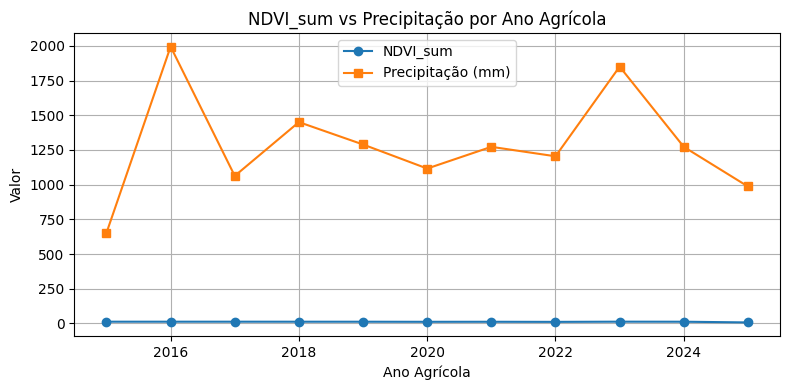

CSV final salvo em: base_palotina_features_2015_2025.csv


In [34]:
# Gráfico simples comparando NDVI acumulado e precipitação por ano agrícola
plt.figure(figsize=(8, 4))
plt.plot(base_final['Ano_Agricola'], base_final['NDVI_sum'], marker='o', label='NDVI_sum')
plt.plot(base_final['Ano_Agricola'], base_final['Precipitacao'], marker='s', label='Precipitação (mm)')
plt.legend()
plt.title('NDVI_sum vs Precipitação por Ano Agrícola')
plt.xlabel('Ano Agrícola')
plt.ylabel('Valor')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"CSV final salvo em: {output_csv}")


# **Modelo**

**Modelagem Preditiva da Produtividade com Machine**


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib

Carregamento e Preparação dos Dados

In [36]:
# Carregar base final com NDVI + clima e dados de produtividade
features = pd.read_csv('base_palotina_features_2015_2025.csv')
prod = pd.read_csv('produtividade_palotina.csv')

# Juntar com a produtividade
df = pd.merge(features, prod[['Ano_Agricola', 'Produtividade_t_ha']], on='Ano_Agricola')


Criação de Novas Variáveis (Engenharia de Atributos)

In [37]:
# Criar coluna de tempo contínuo (facilita modelos)
df['Ano_Continuo'] = df['Ano_Agricola'] - df['Ano_Agricola'].min()

# Média NDVI dos últimos 3 anos (suaviza variações)
df['NDVI_mean_3y'] = df['NDVI_mean'].rolling(window=3, min_periods=1).mean().fillna(0)

# Variação percentual do NDVI de um ano para outro
df['Taxa_Crescimento_NDVI'] = df['NDVI_mean'].pct_change() * 100

# Indicador de estresse hídrico (chuva dividido pela temperatura média)
df['Estresse_Hídrico'] = df['Precipitacao'] / df['Temp_Media']

# Produtividade do ano anterior (lag 1)
df['Produtividade_lag1'] = df['Produtividade_t_ha'].shift(1)


Divisão Temporal dos Dados (Treino e Teste)

In [38]:
train_years = range(2015, 2021)
test_years = range(2021, 2026)

# Seleção de atributos preditores
X = df[['NDVI_max','NDVI_min','NDVI_mean','NDVI_sum',
        'Precipitacao','Temp_Media','Ano_Continuo','NDVI_mean_3y']]

# Variável-alvo: produtividade
y = df['Produtividade_t_ha']

# Separar dados de treino e teste com base no ano
X_train = X[df['Ano_Agricola'].isin(train_years)]
y_train = y[df['Ano_Agricola'].isin(train_years)]
X_test = X[df['Ano_Agricola'].isin(test_years)]
y_test = y[df['Ano_Agricola'].isin(test_years)]


Normalização dos Dados

In [39]:
# Normalizar os dados para evitar que variáveis com escalas diferentes dominem o modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Configuração de Modelos e GridSearch

In [40]:
# Definir modelos e hiperparâmetros para busca automática
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5],
            'n_estimators': [100, 200]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'max_depth': [2, 3],
            'learning_rate': [0.1, 0.05]
        }
    }
}


Validação Cruzada Temporal (Time Series)

In [41]:
tscv = TimeSeriesSplit(n_splits=3, gap=2)
best_models = {}

for name, config in models.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train_scaled, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Melhores parâmetros para {name}: {grid_search.best_params_}")


Melhores parâmetros para RandomForest: {'max_depth': 3, 'n_estimators': 100}
Melhores parâmetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 2}


Avaliação dos Modelos no Conjunto de Teste

In [42]:
# Avaliar modelos no período de teste
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }


Autocorrelação da Produtividade ao Longo do Tempo

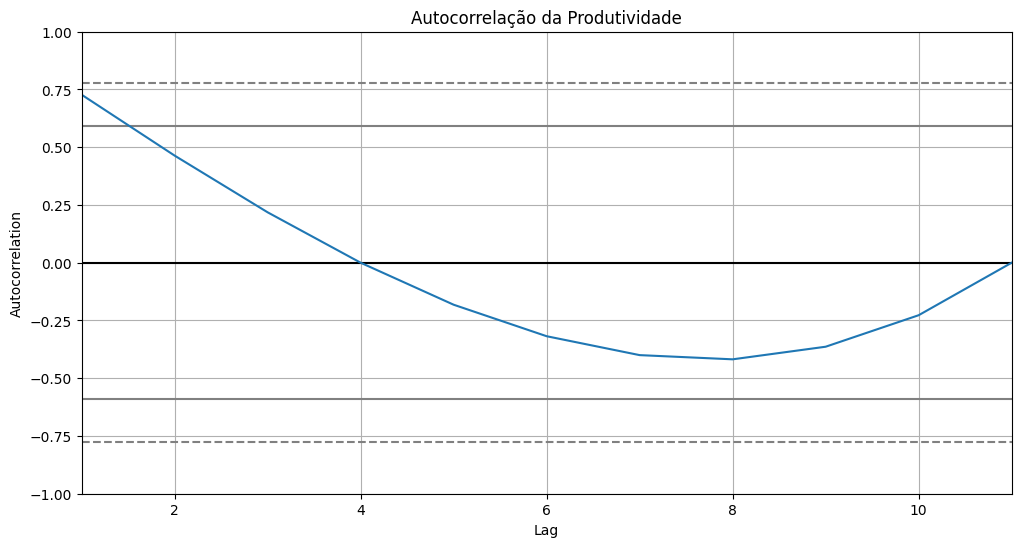

In [43]:
plt.figure(figsize=(12,6))
pd.plotting.autocorrelation_plot(df['Produtividade_t_ha'])
plt.title('Autocorrelação da Produtividade')
plt.show()


Importância das Variáveis (Features)

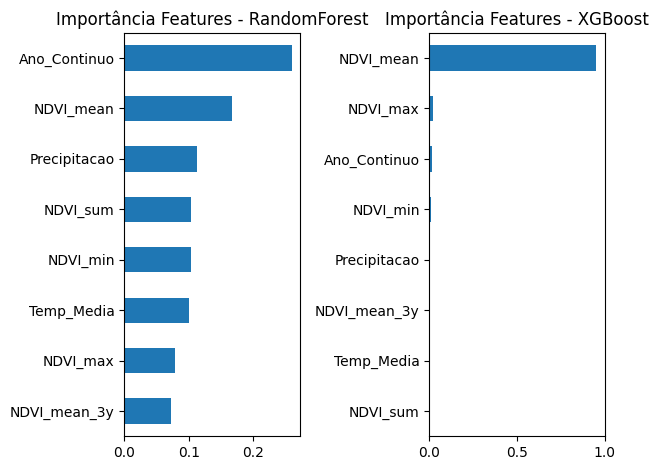

In [44]:
for i, (name, model) in enumerate(best_models.items(), 1):
    plt.subplot(1, len(best_models), i)
    if hasattr(model, 'feature_importances_'):
        pd.Series(model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
    plt.title(f'Importância Features - {name}')
plt.tight_layout()
plt.show()


Comparação Visual: Valor Real vs Valor Predito

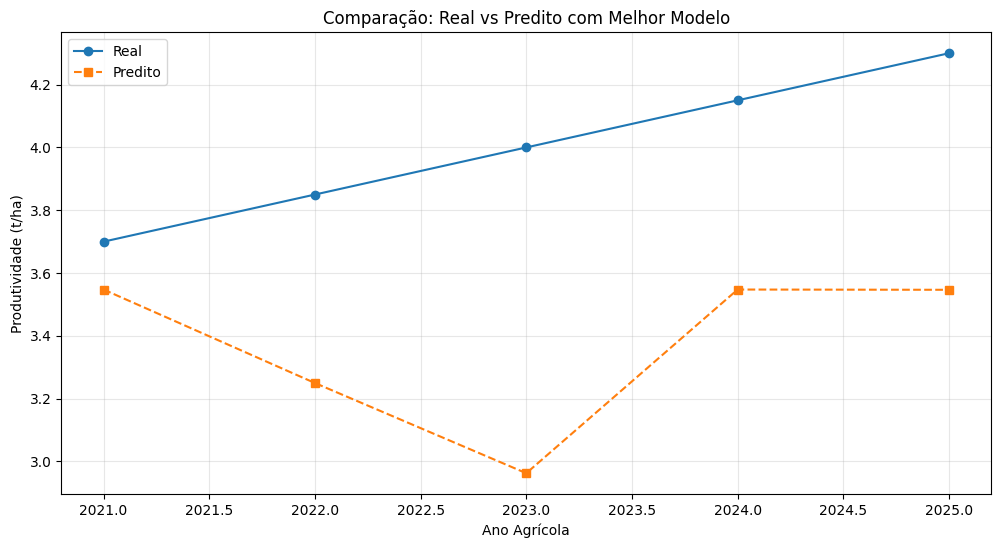

In [45]:
# Usa o melhor modelo (com menor RMSE)
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
best_model = best_models[best_model_name]

test_df = df[df['Ano_Agricola'].isin(test_years)].copy()
test_df['Predito'] = best_model.predict(X_test_scaled)

plt.figure(figsize=(12,6))
plt.plot(test_df['Ano_Agricola'], test_df['Produtividade_t_ha'], marker='o', label='Real')
plt.plot(test_df['Ano_Agricola'], test_df['Predito'], marker='s', linestyle='--', label='Predito')
plt.title('Comparação: Real vs Predito com Melhor Modelo')
plt.xlabel('Ano Agrícola')
plt.ylabel('Produtividade (t/ha)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Resumo Final do Desempenho

In [46]:
# Avaliação detalhada no conjunto de teste
y_pred_test = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Desempenho final no teste ({best_model_name}):")
print(f"RMSE: {test_rmse:.2f}, R²: {test_r2:.2f}, MAE: {test_mae:.2f}")


Desempenho final no teste (XGBoost):
RMSE: 0.78, R²: -12.50, MAE: 0.75


Criação de Tabela Comparativa (Real vs Predito)

In [47]:
test_years = range(2021, 2026)
pred_df = df[df['Ano_Agricola'].isin(test_years)][['Ano_Agricola', 'Produtividade_t_ha']].copy()

# Previsão com o melhor modelo
pred_df['Predito_t_ha'] = best_model.predict(X_test)
pred_df = pred_df.round(2)
pred_df = pred_df.rename(columns={'Produtividade_t_ha': 'Real_t_ha'})

print("\nComparação final no período de teste:")
print(pred_df)



Comparação final no período de teste:
    Ano_Agricola  Real_t_ha  Predito_t_ha
6           2021       3.70          3.25
7           2022       3.85          3.25
8           2023       4.00          3.25
9           2024       4.15          3.25
10          2025       4.30          3.25


Salvar Modelo e Escalonador



In [48]:
joblib.dump(best_model, 'melhor_modelo_produtividade.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']